In [ ]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 --version

In [1]:
import os
import numpy as np
from numpy import linalg as LA
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
from seaborn import color_palette

# animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

## Complex laplacian

In [160]:
"""
- Generate the set of neightborns of i (index) from the edges set -
"""
def gen_Ni(i,n,edges_set):
    N_i = []
    for k in range(n):
        if i != k and ((i+1,k+1) in edges_set or (k+1,i+1) in edges_set):
            N_i.append(k)
    return N_i

"""
- Generate the edges set from Z -
"""
def gen_edges_set(Z):
    E = set()
    for edge in Z:
        E.add(edge)
        E.add((edge[1], edge[0]))
    return E

"""
- Generate the incidence matrix B from the ordered edges set Z -
"""
def gen_inc_matrix(n, Z):
    B = np.zeros((n,len(Z)))
    for i in range(n):
        k = 0
        for edge in Z: # edge = (Z_k^head, Z_k^tail)
            if i+1 == edge[1]: # if tail
                B[i,k] = 1 
            elif i+1 == edge[0]: # if head
                B[i,k] = -1 
            k = k+1
    return B

"""
- Generate the components matrix M from the ordered edges set Z 
  and mu_ij -
"""
def gen_compnts_matrix(n, Z, mu_matrix):
    M = np.zeros((n,len(Z)), dtype=complex)
    for i in range(n):
        k = 0
        for edge in Z: # edge = (Z_k^head, Z_k^tail)
            if i+1 == edge[1]: # if tail
                M[i,k] = mu_matrix[i,edge[0]-1]  # mu_{i Z_k^head}
            elif i+1 == edge[0]: # if head
                M[i,k] = -mu_matrix[i,edge[1]-1] # mu_{i Z_k^tail}
            k = k+1
    return M

"""
- Generate the weights accordangly to a desired formation shape
  and the incidence matrix -
  REF: https://ieeexplore.ieee.org/abstract/document/6750042
"""
def gen_weights(p_star, edges_set, N_list):
    n = len(p_star)
    W = np.zeros((n,n), dtype=complex)

    for i in range(n):
        # compute the weights of the first two neightborns
        j,k = N_list[i][0:2]
        w_vector = (1+2j)*np.array([p_star[i] - p_star[k], 
                                    p_star[j] - p_star[i]], dtype=complex)

        W[i,j], W[i,k] = w_vector[0], w_vector[1]

    return W

"""
- Generate the Complex Laplacian matrix -
"""
def gen_laplacian(n, edges_set, W, N_list):
    L = np.zeros((n,n), dtype=complex)
    for i in range(n):
        N_i = N_list[i]
        for j in range(n):
            if i == j:
                L[i,j] = np.sum(W[i,N_i])
            elif j in N_i:
                L[i,j] = - W[i,j]
    return L

In [226]:
"""
"""
class simulator:
    def __init__(self, p0, dt):
        # State variables
        self.p, self.dt = p0, dt
        self.n = len(p0)
        self.t = 0

    def u_control(self, h, K, L):
        u = -h * K @ L @ self.p[:,None]
        return u[:,0]
    
    def int_euler(self, h, K, L):
        self.p = self.p + self.u_control(h, K, L) * self.dt

"""
"""
class sim_frame:
    def __init__(self, n, Z, p_star, p0, tf, dt = 0.001,
                 h = 1, K = None, kappa = 1,
                 debug = False):
        
        self.data = {"p": None}
        np.random.seed(2024)
        self.debug = debug

        # Graph
        self.n = n
        self.Z = Z
        self.E = gen_edges_set(Z)

        # Desired formation
        self.p_star = p_star

        # Initial conditions
        self.p0 = p0
        self.tf = tf
        self.dt = dt

        # Controller
        self.h = h
        self.kappa = kappa

        if K is None:
            self.K = np.eye(n)
        else:
            self.K = K
        self.K_inv = LA.inv(K)
        
        # Generate all the neighbors sets Ni
        self.Ni_list = []
        for i in range(n):
            self.Ni_list.append(gen_Ni(i,n,self.E))

        # Generating weights and laplacian matrix
        self.B = gen_inc_matrix(self.n, self.Z)
        self.W = gen_weights(self.p_star, self.E, self.Ni_list)
        self.L = gen_laplacian(self.n, self.E, self.W, self.Ni_list)

        if self.debug:
            print("B = \n", self.B)
            print("L = \n", self.L)
            print("\nL@1_n = \n", self.L @ (np.ones((n,1))))
            print("\nL@p^star = \n", self.L @ p_star[:,None])
            print("\nL eigen_values:")
            for i,eigen in enumerate(LA.eig(self.L)[0]):
                print("lambda_{:d} = {:f}".format(i,eigen))
        
        # Initialise the components matrix and the modified laplacian
        self.L_mod = np.copy(self.L)

        # Generating the simulator
        self.simulator = simulator(self.p0, self.dt)

    def set_velocity(self, vx, vy, a, omega):
        # Stack velocity vector
        vf = (vx + vy*(1j))*np.ones(self.n) + a*self.p_star + omega*self.p_star*(1j)

        # Matrix of the motion marameters mu_ij 
        mu_matrix = np.zeros((self.n,len(self.Z)), dtype=complex)
        for i in range(self.n):
            mu_i = np.zeros(len(self.Z), dtype=complex)
            j_neig = self.Ni_list[i][0]
            mu_i[j_neig] = vf[i]/(self.p_star[i] - self.p_star[j_neig])
            mu_matrix[i,:] = mu_i

        M = gen_compnts_matrix(self.n, self.Z, mu_matrix)
        self.L_mod = self.L - self.kappa/self.h * self.K_inv @ M @ self.B.T

        if self.debug:
            print("\nv_f = \n", vf)
            print("\nM = \n", M)
            print("\nL@1_n = \n", self.L @ (np.ones((self.n,1))))
            print("\nL@v_f = \n", self.L @ vf[:,None]) #TODO: thm. 3
            print("\nL eigen_values:")
            for i,eigen in enumerate(LA.eig(self.L_mod)[0]):
                print("lambda_{:d} = {:f}".format(i,eigen))

    def numerical_simulation(self):
        # Integration steps
        its = int(self.tf/self.dt)

        # Init data arrays
        pdata = np.empty([its,self.n], dtype=complex)
        
        # Numerical simulation
        for i in tqdm(range(its)):
            pdata[i,:] = self.simulator.p
            # Robots simulator euler step integration
            self.simulator.int_euler(self.h, self.K, self.L_mod)

        self.data["p"] = pdata
    
    def plot(self):
        # Extract data
        pdata = self.data["p"]

        # Figure init and configuration
        fig = plt.figure()
        ax = fig.subplots()

        ax.grid(True)
        ax.set_xlim([-20,20])
        ax.set_ylim([-20,20])

        # Plotting
        colors = ["k", "b", "r", "g"]
        for i in range(self.n):
            ax.plot(pdata[:,i].real, pdata[:,i].imag, c=colors[i], lw=0.8)
            ax.plot(pdata[0,i].real, pdata[0,i].imag, "x", c=colors[i])
            ax.plot(pdata[-1,i].real, pdata[-1,i].imag, ".", c=colors[i])

        for edge in self.Z:
            i,j = np.array(edge)-1
            ax.plot([pdata[-1,i].real, pdata[-1,j].real], 
                    [pdata[-1,i].imag, pdata[-1,j].imag], "k--", lw=0.8)

        plt.show()

In [272]:
## Parameters #####
n = 4
Z = ((1,2), (2,3), (3,4), (4,1))
p_star = np.array([0-1j, 1+0j, 0+1j, -1+0j], dtype=complex) # square
p0 = np.array([-10-1j, 4-2j,0+4j,-0.5+0.5j], dtype=complex)
tf = 4
h = 0.1
K = np.eye(n)

## Generate the simulation frame #####
args = {"n":n, "Z":Z, "p_star":p_star, "p0":p0, "tf":tf, "h":h, "K":K, "debug":True}
sim_fr = sim_frame(**args)

B = 
 [[-1.  0.  0.  1.]
 [ 1. -1.  0.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  1. -1.]]
L = 
 [[ 2.+4.j -3.-1.j  0.+0.j  1.-3.j]
 [-3.-1.j  4.-2.j -1.+3.j  0.+0.j]
 [ 0.+0.j  1.-3.j  2.+4.j -3.-1.j]
 [-1.+3.j  0.+0.j -3.-1.j  4.-2.j]]

L@1_n = 
 [[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

L@p^star = 
 [[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

L eigen_values:
lambda_0 = 6.000000+2.000000j
lambda_1 = -0.000000-0.000000j
lambda_2 = 6.000000+2.000000j
lambda_3 = -0.000000+0.000000j



v_f = 
 [ 1.+0.j  0.+1.j -1.+0.j  0.-1.j]

M = 
 [[ 0.5-0.5j  0. +0.j   0. +0.j   0. +0.j ]
 [ 0.5+0.5j -0. -0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0.5+0.5j -0. -0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0.5-0.5j]]

L@1_n = 
 [[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

L@v_f = 
 [[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

L eigen_values:
lambda_0 = 11.000000-3.000000j
lambda_1 = 0.000000-10.000000j
lambda_2 = 1.000000-3.000000j
lambda_3 = 0.000000+0.000000j


100%|██████████| 4000/4000 [00:00<00:00, 125240.49it/s]


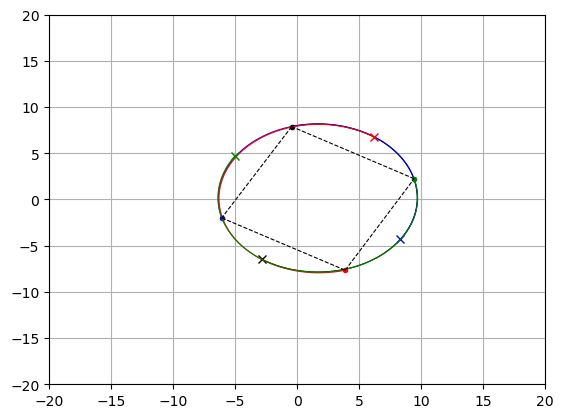

In [284]:
## Launch the simulation and plot #####
sim_fr.set_velocity(0, 0, 0, 1)

sim_fr.numerical_simulation()
sim_fr.plot()